In [1]:
import matplotlib.pyplot as plt
from utils.provider import get_frame_annotation, plot_confusion_matrix_2, get_stratified_UCEIS_accuracies, convert_multiclass_to_binary_class, get_all_level_bucketing_accuracy
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, cohen_kappa_score
import numpy as np
from scipy.signal import medfilt
import math
import json
from statistics import mean

In [2]:
def get_thresholded_values(float_array, threshold=0.25):
    threshold_rounded = []
    for item in float_array:
        if item - int(item) < threshold:
            threshold_rounded.append(round(item))
        else:
            threshold_rounded.append(math.ceil(item))
    return threshold_rounded

In [3]:
def get_ratios(scores):
    size = len(scores)
    unique_items = sorted(list(set(scores)))
    score_ratios = {}
    for item in unique_items:
        score_ratios[item] = scores.count(item)/size
    return score_ratios

In [4]:
def calculate_final_score(score_ratios, video_length, subscore_type=0):
    """
    subscore_type: 0=Vacular Pattern (0-2)
                   1=Bleeding (0-3)
                   2=Erosion (0-3)
    """
    
    if video_length > 100000:
        VP_threshold_2 = 200
        VP_threshold_2_1 = 200

        B_threshold_3 = 200
        B_threshold_3_2 = 200
        B_threshold_3_2_1 = 200

        if subscore_type == 0:
            if score_ratios.get(2, 0)*video_length > VP_threshold_2:
                return 2
            elif (score_ratios.get(2, 0)+score_ratios.get(1, 0))*video_length > VP_threshold_2_1:
                return 1
            else:
                return 0        
        elif subscore_type == 1 or subscore_type == 2:
            if score_ratios.get(3, 0)*video_length > B_threshold_3:
                return 3
            elif (score_ratios.get(3, 0)+score_ratios.get(2, 0))*video_length > B_threshold_3_2:
                return 2
            elif (score_ratios.get(3, 0)+score_ratios.get(2, 0)+score_ratios.get(1, 0))*video_length > B_threshold_3_2_1:
                return 1
            else:
                return 0
        else:
            raise Exception("No subscore_type as "+str(subscore_type)+". Valid subscore_types: 0, 1, 2.")
    else:
        VP_threshold_2 = 0.25
        VP_threshold_2_1 = 0.25

        B_threshold_3 = 0.25
        B_threshold_3_2 = 0.25
        B_threshold_3_2_1 = 0.25

        if subscore_type == 0:
            if score_ratios.get(2, 0) > VP_threshold_2:
                return 2
            elif (score_ratios.get(2, 0)+score_ratios.get(1, 0)) > VP_threshold_2_1:
                return 1
            else:
                return 0        
        elif subscore_type == 1 or subscore_type == 2:
            if score_ratios.get(3, 0) > B_threshold_3:
                return 3
            elif (score_ratios.get(3, 0)+score_ratios.get(2, 0)) > B_threshold_3_2:
                return 2
            elif (score_ratios.get(3, 0)+score_ratios.get(2, 0)+score_ratios.get(1, 0)) > B_threshold_3_2_1:
                return 1
            else:
                return 0
        else:
            raise Exception("No subscore_type as "+str(subscore_type)+". Valid subscore_types: 0, 1, 2.")
    

In [5]:
f = open("video_prediction_results.json")
annotations = json.load(f)

In [6]:
use_smart_threshold = True
smart_threshold = 0.3
median_filter_size = 75

In [7]:
true_video_scores = []
expert_system_video_score = []
pred_video_scores = []

final_vascular_pattern_scores=[]
final_bleeding_scores=[]
final_erosion_scores=[]

for annotation in annotations:
    true_video_scores.append(annotation["video_score"])
    
    # Classical method
    pred_video_scores.append(mean(annotation["UCEIS"]))
    
    # Expert method
    Vascular_Pattern_thresholded = medfilt(annotation["Vascular_Pattern"], median_filter_size)
    Bleeding_thresholded = medfilt(annotation["Bleeding"], median_filter_size)
    Erosion_thresholded = medfilt(annotation["Erosion"], median_filter_size)

    Vascular_Pattern_thresholded = [int(item) for item in Vascular_Pattern_thresholded]
    Bleeding_thresholded = [int(item) for item in Bleeding_thresholded]
    Erosion_thresholded = [int(item) for item in Erosion_thresholded]
    
    vp_ratios = get_ratios(Vascular_Pattern_thresholded)
    bleeding_ratios = get_ratios(Bleeding_thresholded)
    erosion_ratios = get_ratios(Erosion_thresholded)
    
    expert_system_video_score.append(calculate_final_score(vp_ratios, len(Vascular_Pattern_thresholded), 0)+
                                    calculate_final_score(bleeding_ratios, len(Bleeding_thresholded), 1)+
                                    calculate_final_score(erosion_ratios, len(Erosion_thresholded), 2))
    
    

[0.09259259259259259, 0.12962962962962962, 0.07407407407407407, 0.07407407407407407, 0.3148148148148148, 0.25925925925925924, 0.018518518518518517, 0.018518518518518517, 0.018518518518518517]


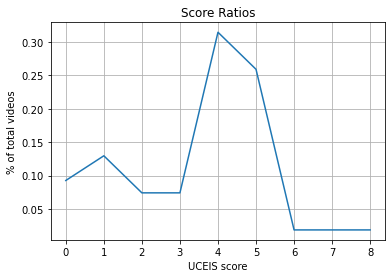

In [8]:
unique_items = sorted(list(set(true_video_scores)))
score_ratios = []
for item in unique_items:
    score_ratios.append(true_video_scores.count(item))
score_ratios = [x/sum(score_ratios) for x in score_ratios]

print(score_ratios)
plt.title("Score Ratios")
plt.xlabel("UCEIS score")
plt.ylabel("% of total videos")
plt.grid("on")
plt.plot(score_ratios)

In [9]:
predictions_rounded = [round(x) for x in pred_video_scores]
predictions_ceil = [math.ceil(x) for x in pred_video_scores]
predictions_thresholded = get_thresholded_values(pred_video_scores, 0.25)

In [10]:
for original, thresholded in zip(pred_video_scores, predictions_thresholded):
    print(original," - ", thresholded)

0.5241730279898219  -  1
1.6806853582554517  -  2
5.281608149899945  -  6
3.439265183704074  -  4
4.028453663076719  -  4
4.943820224719101  -  5
3.1192930780559647  -  3
2.2667883211678834  -  3
4.644403500690926  -  5
4.072522159548751  -  4
4.3076923076923075  -  5
0  -  0
3.3  -  4
6.949397590361446  -  7
4.962962962962963  -  5
1.4836065573770492  -  2
4  -  4
3.1572147001934234  -  3
1.2228356890459364  -  1
4.329965649626187  -  5
4.732125834127741  -  5
4.9411764705882355  -  5
4.485714285714286  -  5
4.9  -  5
4.861861861861862  -  5
4.380332610267534  -  5
6.01067615658363  -  6
3.104651162790698  -  3
0.9473684210526315  -  1
3.99203187250996  -  4
4.495914342068188  -  5
3.768692031042968  -  4
4.862745098039215  -  5
3.453222453222453  -  4
4.478747772970221  -  5
4.5488372093023255  -  5
3.627113945106737  -  4
5.289685274523317  -  6
5.738255033557047  -  6
0.0550098231827112  -  0
4.3137455288707205  -  5
5.97020725388601  -  6
4.011627906976744  -  4
3.6316365626710456

UCEIS Accuracy (rounded):  0.4074074074074074
Confusion matrix, without normalization
[[3 1 0 0 0 1 0 0 0]
 [1 3 2 0 1 0 0 0 0]
 [0 0 0 3 1 0 0 0 0]
 [0 0 0 1 3 0 0 0 0]
 [0 0 0 2 8 5 2 0 0]
 [0 0 0 1 4 7 1 1 0]
 [0 0 0 0 0 1 0 0 0]
 [0 0 0 0 0 1 0 0 0]
 [0 0 0 0 0 1 0 0 0]]


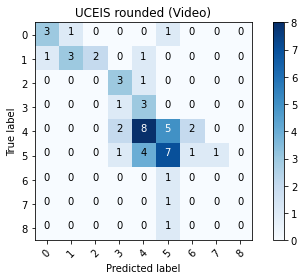

UCEIS Accuracy (ceil):  0.37037037037037035
Confusion matrix, without normalization
[[2 1 1 0 0 1 0 0 0]
 [0 3 2 1 1 0 0 0 0]
 [0 0 0 0 4 0 0 0 0]
 [0 0 0 0 1 3 0 0 0]
 [0 0 0 0 5 9 2 1 0]
 [0 0 0 0 2 9 2 1 0]
 [0 0 0 0 0 0 1 0 0]
 [0 0 0 0 0 1 0 0 0]
 [0 0 0 0 0 1 0 0 0]]


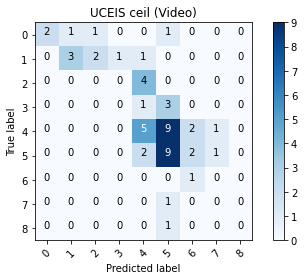

UCEIS Accuracy (thresholded):  0.37037037037037035
Confusion matrix, without normalization
[[3 1 0 0 0 1 0 0 0]
 [1 2 2 1 1 0 0 0 0]
 [0 0 0 2 2 0 0 0 0]
 [0 0 0 0 2 2 0 0 0]
 [0 0 0 1 6 7 3 0 0]
 [0 0 0 0 2 9 2 1 0]
 [0 0 0 0 0 1 0 0 0]
 [0 0 0 0 0 1 0 0 0]
 [0 0 0 0 0 1 0 0 0]]


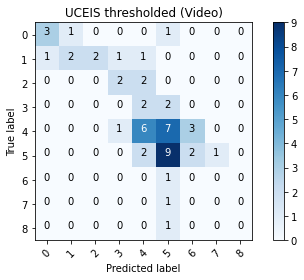

UCEIS Accuracy (expert):  0.35185185185185186
Confusion matrix, without normalization
[[3 0 1 0 1 0 0 0 0]
 [1 3 0 2 1 0 0 0 0]
 [0 0 0 0 4 0 0 0 0]
 [0 0 0 0 3 1 0 0 0]
 [0 0 0 2 4 9 0 2 0]
 [0 0 0 0 3 9 0 2 0]
 [0 0 0 0 0 1 0 0 0]
 [0 0 0 0 0 1 0 0 0]
 [0 0 0 0 0 0 1 0 0]]


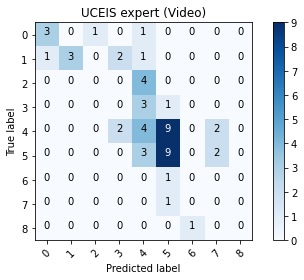

In [11]:
cm_UCEIS = confusion_matrix(true_video_scores, predictions_rounded, labels=[0, 1, 2, 3, 4, 5, 6, 7, 8])
accuracy_UCEIS = accuracy_score(true_video_scores, predictions_rounded)

print("UCEIS Accuracy (rounded): ", accuracy_UCEIS)
plot_confusion_matrix_2(cm_UCEIS, classes=["0", "1", "2", "3", "4", "5", "6", "7", "8"], title="UCEIS rounded (Video)")
plt.show()

cm_UCEIS_ceil = confusion_matrix(true_video_scores, predictions_ceil, labels=[0, 1, 2, 3, 4, 5, 6, 7, 8])
accuracy_UCEIS_ceil = accuracy_score(true_video_scores, predictions_ceil)

print("UCEIS Accuracy (ceil): ", accuracy_UCEIS_ceil)
plot_confusion_matrix_2(cm_UCEIS_ceil, classes=["0", "1", "2", "3", "4", "5", "6", "7", "8"], title="UCEIS ceil (Video)")
plt.show()

cm_UCEIS_thresholded = confusion_matrix(true_video_scores, predictions_thresholded, labels=[0, 1, 2, 3, 4, 5, 6, 7, 8])
accuracy_UCEIS_thresholded = accuracy_score(true_video_scores, predictions_thresholded)

print("UCEIS Accuracy (thresholded): ", accuracy_UCEIS_thresholded)
plot_confusion_matrix_2(cm_UCEIS_thresholded, classes=["0", "1", "2", "3", "4", "5", "6", "7", "8"], title="UCEIS thresholded (Video)")
plt.show()

cm_UCEIS_expert = confusion_matrix(true_video_scores, expert_system_video_score, labels=[0, 1, 2, 3, 4, 5, 6, 7, 8])
accuracy_UCEIS_expert = accuracy_score(true_video_scores, expert_system_video_score)

print("UCEIS Accuracy (expert): ", accuracy_UCEIS_expert)
plot_confusion_matrix_2(cm_UCEIS_expert, classes=["0", "1", "2", "3", "4", "5", "6", "7", "8"], title="UCEIS expert (Video)")
plt.show()

**Set predictions for the rest of the scores**

In [12]:
predictions = expert_system_video_score
# predictions = predictions_thresholded

**Video level quadratic weighted kappa score**

In [13]:
quadratic_kappa_score = cohen_kappa_score(true_video_scores, predictions, weights="quadratic")
print("Quadratic Kappa Score (9-classes): ", quadratic_kappa_score)

Quadratic Kappa Score (9-classes):  0.7030593881223755


**Video level remission results**

UCEIS Accuracy (0 vs 1-8):  0.9444444444444444
Confusion matrix, without normalization
[[ 3  2]
 [ 1 48]]


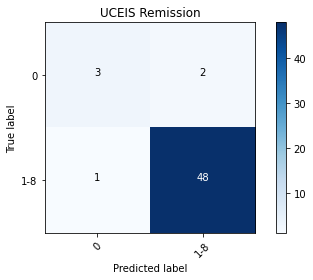

In [14]:
y_true_remission = convert_multiclass_to_binary_class(true_video_scores)
y_pred_remission = convert_multiclass_to_binary_class(predictions)

cm_UCEIS_remission = confusion_matrix(y_true_remission, y_pred_remission, labels=[0, 1])
accuracy_UCEIS_remission = accuracy_score(y_true_remission, y_pred_remission)

print("UCEIS Accuracy (0 vs 1-8): ", accuracy_UCEIS_remission)
plot_confusion_matrix_2(cm_UCEIS_remission, classes=["0", "1-8"], title="UCEIS Remission")
plt.show()

**Video level remission kappa score**

In [15]:
kappa_score = cohen_kappa_score(y_true_remission, y_pred_remission)
print("Remission Kappa Score: ", kappa_score)

Remission Kappa Score:  0.6367713004484306


**Video level "Qualification" results**

UCEIS Qualification (0-4 vs 5-8):  0.7222222222222222
Confusion matrix, without normalization
[[25 12]
 [ 3 14]]


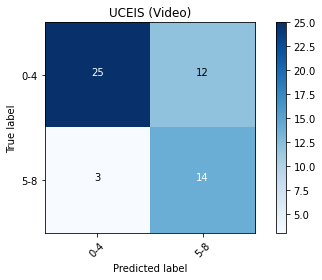

In [16]:
y_true_remission = convert_multiclass_to_binary_class(true_video_scores, zero_classes=[0, 1, 2, 3, 4])
y_pred_remission = convert_multiclass_to_binary_class(predictions, zero_classes=[0, 1, 2, 3, 4])

cm_UCEIS_remission = confusion_matrix(y_true_remission, y_pred_remission, labels=[0, 1])
accuracy_UCEIS_remission = accuracy_score(y_true_remission, y_pred_remission)

print("UCEIS Qualification (0-4 vs 5-8): ", accuracy_UCEIS_remission)
plot_confusion_matrix_2(cm_UCEIS_remission, classes=["0-4", "5-8"], title="UCEIS (Video)")
plt.show()